<a href="http://landlab.github.io"><img style="float: left" src="../../media/landlab_header.png"></a>

# Large scale landscape evolution model with Priority flood flow router and Space_v2 on real topography
<hr>

The priority flood flow director is designed to calculate flow properties over large scale grids. In the following notebook we illustrate how the priority flood flow accumulator can be used to simulate landscape evolution using the SPAVE_V2 Landlab component

First we will import all the modules we need. 

In [1]:
import sys, time, os
from pathlib import Path
import copy
import numpy as np
import matplotlib as mpl
from tqdm import tqdm
import matplotlib.pyplot as plt

from landlab.components import (
    SpaceLargeScaleEroder,
    PriorityFloodFlowRouter,
    FlowAccumulator,
    DepressionFinderAndRouter,
)

from landlab.io.netcdf import read_netcdf
from landlab.utils import get_watershed_mask
from landlab import RasterModelGrid, imshowhs_grid, imshow_grid
from landlab.io import read_esri_ascii, write_esri_ascii
from bmi_topography import Topography

## 1. Download SRTM image using the bmi-topography package
See [Bedrock landslides on existing topography (SRTM DEM) notebook](../hylands_real/bedrockLandslides_on_DEMs.ipynb)
for more info on the use of bmi-topography. 


/Users/beca4397/Google_Drive/HyLands_modeling/tutorials/large_scale_LEM/DEMData/SRTMGL3_39_-106_40_-105.asc


/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:494: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


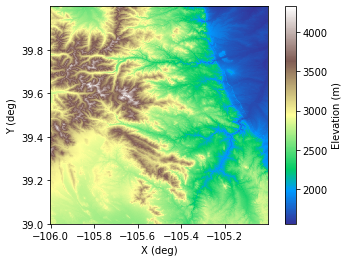

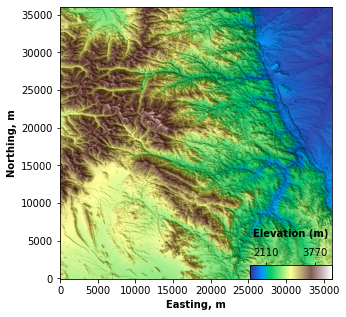

In [2]:
topo = Topography(
    dem_type="SRTMGL3",
    south=39.5,
    north=40,
    west=-106,
    east=-105.5,
    output_format="AAIGrid",
    cache_dir="DEMData//"
    )

# topo = Topography(
#     dem_type="SRTMGL3",
#     south=39,
#     north=40,
#     west=-106,
#     east=-105,
#     output_format="AAIGrid",
#     cache_dir="DEMData//"
#     )

fname = topo.fetch()
print(fname)
dem = topo.load()

# Read DEM as Lanlab grid
grid_geog, elev = read_esri_ascii(fname, name='topographic__elevation')    

#Show dem
plt.figure()
cmap = copy.copy(mpl.cm.get_cmap("terrain"))
imshow_grid(grid_geog, 'topographic__elevation',cmap =cmap,
            grid_units=("deg", "deg"),colorbar_label="Elevation (m)")
plt.show()

# Reproject the DEM
mg = RasterModelGrid(
    (grid_geog.number_of_node_rows, grid_geog.number_of_node_columns), xy_spacing=30.0
)
mg.add_field("topographic__elevation", elev, at="node")

plt.figure(figsize=(5,5))
cmap = copy.copy(mpl.cm.get_cmap("terrain"))
imshowhs_grid(mg, 'topographic__elevation',cmap =cmap,
            grid_units=("m", "m"),var_name="Elevation (m)", colorbar_label_y = -50)
plt.show()

Create raster grid

In [3]:
s = mg.add_zeros("soil__depth", at="node", dtype=float)
mg.at_node["soil__depth"][mg.core_nodes] += 0.5
mg.at_node["topographic__elevation"] += mg.at_node["soil__depth"]

fr = FlowAccumulator(mg, flow_director='D8')
df = DepressionFinderAndRouter(mg)

ha = SpaceLargeScaleEroder(mg, K_sed=0.00005, K_br=0.00005, phi=0.3, H_star=1)

br = mg.at_node["bedrock__elevation"]
z = mg.at_node["topographic__elevation"]

space_dt = 50

In [4]:
z_ori = np.array(z)
t1 = time.time()
for i in tqdm(range(1)):
    # Uplift
    br[mg.core_nodes] += 0.0001 * space_dt
    # Mimic mass movements by adding some random noise to the DEM
    br[mg.core_nodes] += 10*(np.random.rand(mg.number_of_core_nodes)-0.5)
    z[mg.core_nodes] = br[mg.core_nodes] + s[mg.core_nodes]
    fr.run_one_step()
    df.map_depressions()
    ha.run_one_step(dt=space_dt)

t_span1 = time.time() - t1
print('Total run time is %.f s' %t_span1)

100%|█████████████████████████████████████████████| 1/1 [01:35<00:00, 95.43s/it]

Total run time is 95 s


In [5]:
grid_geog.number_of_node_columns

1200

/var/folders/td/c9cs44w55_n07lr946xl3q8w0000gn/T/ipykernel_5021/3723530886.py:3: RuntimeWarning: invalid value encountered in sqrt
  drape1 = np.sqrt(erosion)
/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:674: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cmap.set_bad(alpha=0.0)


Text(0.5, 1.0, 'Final topographic__elevation')

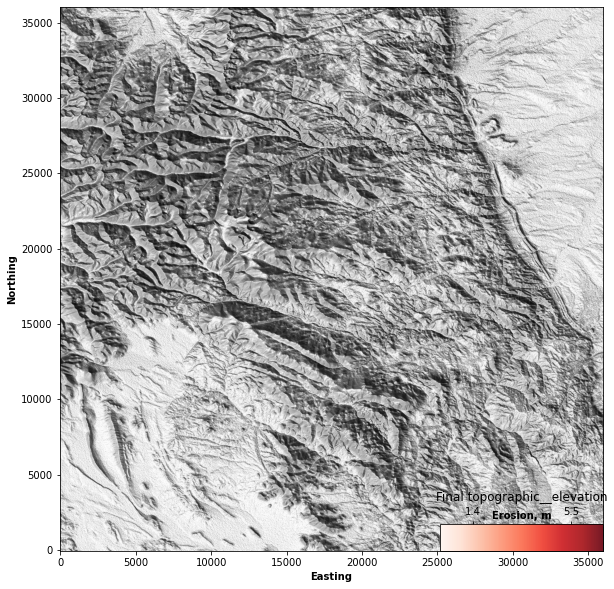

In [6]:
plt.figure(figsize=(10,10))
erosion =  z_ori - mg.at_node['topographic__elevation']
drape1 = np.sqrt(erosion)
drape1[np.isnan(drape1)]=0

imshowhs_grid(mg,'topographic__elevation', 
              drape1 = drape1,
              alpha = 0.9,
              plot_type = 'Drape1' , 
              cmap="Reds",
              var_name = 'Erosion, m' ,
              thres_drape1 = 0.01
             )
plt.title("Final topographic__elevation")

In [7]:
mg2 = RasterModelGrid(
    (grid_geog.number_of_node_rows, grid_geog.number_of_node_columns), xy_spacing=30.0
)
z2 = mg2.add_field("topographic__elevation", elev, at="node")
s2 = mg2.add_zeros("soil__depth", at="node", dtype=float)
mg2.at_node["soil__depth"][mg2.core_nodes] += 0.5
mg2.at_node["topographic__elevation"] += mg2.at_node["soil__depth"]

fr2 = PriorityFloodFlowRouter(mg2, flow_metric="D8", update_flow_depressions=True)

ha2 = SpaceLargeScaleEroder(mg2, K_sed=0.00005, K_br=0.00005, phi=0.3, H_star=1)

br2 = mg2.at_node["bedrock__elevation"]
space_dt = 50

In [8]:
z_ori = np.array(z2)
t1 = time.time()
for i in tqdm(range(1)):
    # Uplift
    br2[mg2.core_nodes] += 0.001 * space_dt 
    # Mimic mass movements by adding some random noise to the DEM
    br[mg.core_nodes] += 10*(np.random.rand(mg.number_of_core_nodes)-0.5)
    z2[mg2.core_nodes] = br2[mg2.core_nodes] + s2[mg2.core_nodes]
    fr2.run_one_step()
    ha2.run_one_step(dt=space_dt)

t_span2 = time.time() - t1

print('Total run time is %.f s' %t_span2)

100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.82s/it]

Total run time is 26 s


/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:454: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("terrain").copy()
  cmap.set_bad(color=color_for_closed)


Text(0.5, 1.0, 'Final topographic__elevation')

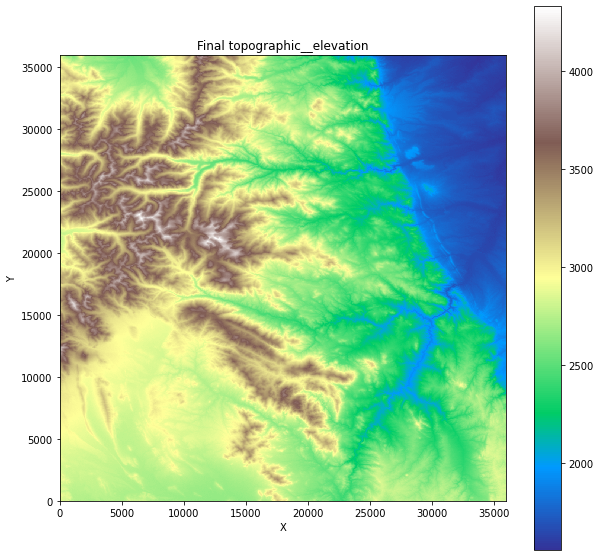

In [9]:
plt.figure(figsize=(10,10))
imshow_grid(mg2, "topographic__elevation", cmap="terrain")
plt.title("Final topographic__elevation")

Text(0, 0.5, 'Seconds')

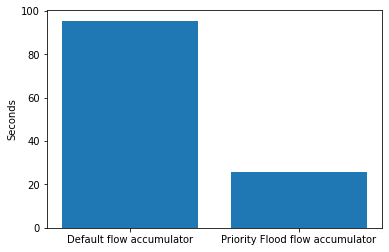

In [10]:
plt.figure()
plt.bar(['Default flow accumulator','Priority Flood flow accumulator'],[t_span1,t_span2])
plt.ylabel('Seconds')

<img style="zoom:50%" src="../../media/RealTopo_Perf_Default_FA_vs_PF_linear_demo.png" alt="RealTopo_Perf_Default_FA_vs_PF_linear_demo"/>

**Figure 1a**: Performance of of default flow accumulator versus Priority Flood flow accumulator for DEMs of increasing size.

<img style="zoom:50%" src="../../media/RealTopo_Perf_Default_FA_vs_PF_log_demo.png" alt="RealTopo_Perf_Default_FA_vs_PF_log_demo"/>

**Figure 1b**: Performance of of default flow accumulator versus Priority Flood flow accumulator for DEMs of increasing size -- log scale. 


<!-- <img style="zoom:50%" src="../../media/Performance_Default_FA_vs_PF_Linear.png" alt="Performance of differnt Flow accumualtors when running the mass conservative Space LEM (linear axes)." />

**Figure 2a**: Performance of of default flow accumulator versus Priorirty Flood flow accumulator for the SPACE numerical landscape evolution model. Note that space_v2 is slightly slower which is due to the structure of the component that facilitates for for bigger timesteps -- log scale.

<img style="zoom:50%" src="../../media/Performance_Default_FA_vs_PF_Log.png" alt="Performance of differnt Flow accumualtors when running the mass conservative Space LEM (log axes)." style="zoom:24%;" />

**Figure 2b**: Performance of of default flow accumulator versus Priorirty Flood flow accumulator for the SPACE numerical landscape evolution model. Note that space_v2 is slightly slower which is due to the structure of the component that facilitates for for bigger timesteps -- log scale. -->



## Back to HyLands tutorial page
[Click here to go back to the tutorial overview page](../index.ipynb)